# Introduction to Quantum Error Correction via the Repetition Code

This notebook will introduce you to repetition coding for quantum error correction. This notebook is adapted from the chapter "Introduction to Quantum Error Correction via the Repetition Code" from the Qiskit textbook.

## Introduction

Quantum computing requires us to encode information in qubits. Most quantum algorithms developed over the past few decades have assumed that these qubits are perfect: they can be prepared in any state we desire, and be manipulated with complete precision. Qubits that obey these assumptions are often known as *logical qubits*.

The last few decades have also seen great advances in finding physical systems that behave as qubits, with better quality qubits being developed all the time. However, the imperfections can never be removed entirely. These qubits will always be much too imprecise to serve directly as logical qubits. Instead, we refer to them as *physical qubits*.

In the current era of quantum computing, we seek to use physical qubits despite their imperfections, by designing custom algorithms and using error mitigation effects. For the future era of fault-tolerance, however, we must find ways to build logical qubits from physical qubits. This will be done through the process of quantum error correction, in which logical qubits are encoded in a large number of physical qubits. The encoding is maintained by constantly putting the physical qubits through a highly entangling circuit. Auxiliary degrees of freedom are also constantly measured, to detect signs of errors and allow their effects to be removed. The operations on the logical qubits required to implement quantum computation will be performed by essentially making small perturbations to this procedure.

Because of the vast amount of effort required for this process, most operations performed in fault-tolerant quantum computers will be done to serve the purpose of error detection and correction. So when benchmarking our progress towards fault-tolerant quantum computation, we must keep track of how well our devices perform error correction.

In this notebook we will look at a particular example of error correction: the repetition code. Though not a true example of quantum error correction — it uses physical qubits to encode a logical *bit*, rather than a qubit — it serves as a simple guide to all the basic concepts in any quantum error correcting code.

## Introduction to the repetition code

### The basics of error correction

The basic ideas behind error correction are the same for quantum information as for classical information. This allows us to begin by considering a very straightforward example: speaking on the phone. If someone asks you a question to which the answer is 'yes' or 'no', the way you give your response will depend on two factors:

* How important is it that you are understood correctly?
* How good is your connection?

Both of these can be parameterized with probabilities. For the first, we can use $P_a$, the maximum acceptable probability of being misunderstood. If you are being asked to confirm a preference for ice cream flavours, and don't mind too much if you get vanilla rather than chocolate, $P_a$ might be quite high. If you are being asked a question on which someone's life depends, however, $P_a$ will be much lower.

For the second we can use $p$, the probability that your answer is garbled by a bad connection. For simplicity, let's imagine a case where a garbled 'yes' doesn't simply sound like nonsense, but sounds like a 'no'. And similarly a 'no' is transformed into 'yes'. Then $p$ is the probability that you are completely misunderstood.

A good connection or a relatively unimportant question will result in $p<P_a$. In this case it is fine to simply answer in the most direct way possible: you just say 'yes' or 'no'.

If, however, your connection is poor and your answer is important, we will have $p>P_a$. A single 'yes' or 'no' is not enough in this case. The probability of being misunderstood would be too high. Instead we must encode our answer in a more complex structure, allowing the receiver to decode our meaning despite the possibility of the message being disrupted. The simplest method is the one that many would do without thinking: simply repeat the answer many times. For example say 'yes, yes, yes' instead of 'yes' or 'no, no no' instead of 'no'.

If the receiver hears 'yes, yes, yes' in this case, they will of course conclude that the sender meant 'yes'. If they hear 'no, yes, yes', 'yes, no, yes' or 'yes, yes, no', they will probably conclude the same thing, since there is more positivity than negativity in the answer. To be misunderstood in this case, at least two of the replies need to be garbled. The probability for this, $P$, will be less than $p$. When encoded in this way, the message therefore becomes more likely to be understood. The code cell below shows an example of this.

In [ ]:
p1 = 0.01
p3 = 3 * p1**2 * (1-p1) + p1**3 # probability of 2 or 3 errors
print('Probability of a single reply being garbled: {}'.format(p1))
print('Probability of a majority of the three replies being garbled: {:.4f}'.format(p3))

If $P<P_a$, this technique solves our problem. If not, we can simply add more repetitions. The fact that $P<p$ above comes from the fact that we need at least two replies to be garbled to flip the majority, and so even the most likely possibilities have a probability of $\sim p^2$. For five repetitions we'd need at least three replies to be garbled to flip the majority, which happens with probability $\sim p^3$. The value for $P$ in this case would then be even lower. Indeed, as we increase the number of repetitions, $P$ will decrease exponentially. No matter how bad the connection, or how certain we need to be of our message getting through correctly, we can achieve it by just repeating our answer enough times.

Though this is a simple example, it contains all the aspects of error correction.
* There is some information to be sent or stored: In this case, a 'yes' or 'no'.
* The information is encoded in a larger system to protect it against noise: In this case, by repeating the message.
* The information is finally decoded, mitigating for the effects of noise: In this case, by trusting the majority of the transmitted messages.

This same encoding scheme can also be used for binary, by simply substituting `0` and `1` for 'yes' and 'no'. It can therefore also be easily generalized to qubits by using the states $\left|0\right\rangle$ and $\left|1\right\rangle$. In each case it is known as the *repetition code*. Many other forms of encoding are also possible in both the classical and quantum cases, which outperform the repetition code in many ways. However, its status as the simplest encoding does lend it to certain applications. One is exactly what it is used for in Qiskit: as the first and simplest test of implementing the ideas behind quantum error correction.

### Correcting errors in qubits

We will now implement these ideas explicitly using Qiskit. To see the effects of imperfect qubits, we simply can simulate the qubits of the prototype devices using a noisy device backend, like we did when implementing Rabi oscillations.

In [ ]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer, execute, IBMQ
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator

provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-06-21 15:14:36,908: Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
# Block 1 - Creating the noisy device backend
noisy_device = provider.get_backend('ibmq_lima')
noisy_device_backend = QasmSimulator.from_backend(noisy_device)

Let's see what effect this has when trying to store a `0` using three qubits in state $\left|0\right\rangle$. We'll repeat the process `shots=10000` times to see how likely different results are.

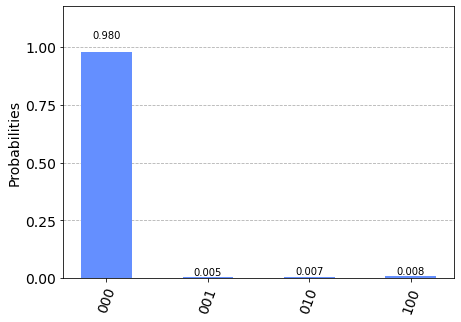

In [ ]:
# Block 2 - Encoding a 0 using 3 qubits. Create a 3 qubit quantum circuit and add a measurement to each qubit. 
# Execute the circuit using the noisy device backend

qc = QuantumCircuit(3,3) # FIll code here - create circuit with three qubits in the 0 state
# Fill code here - measure the qubits
qc.measure(0,0) 
qc.measure(1,1)
qc.measure(2,2)

# Fill code here - run the circuit with the noise model and extract the counts. Plot the histogram of the counts
job = execute(qc, noisy_device_backend, shots = 10000)
results = job.result()
counts = results.get_counts()

plot_histogram(counts)

Here we see that almost all results still come out `'000'`, as they would if there was no noise. Of the remaining possibilities, those with a majority of `0`s are most likely. In total, much less than 10 samples come out with a majority of `1`s. When using this circuit to encode a `0`, this means that $P<1\%$

Now let's try the same for storing a `1` using three qubits in state $\left|1\right\rangle$.

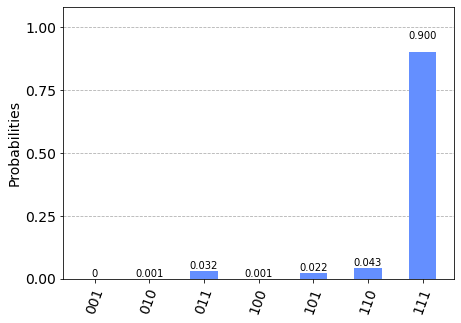

In [ ]:
# Block 3 - Encoding a 1 using 3 qubits. Create a 3 qubit quantum circuit and add X gate to all 3 qubits.
# Add a measurement to each qubit. 
# Execute the circuit using the noisy device backend

qc = QuantumCircuit(3,3) # FIll code here - create circuit with three qubits in the 0 state
# Fill code here - add X gates to each qubit
qc.x(0)
qc.x(1)
qc.x(2)
# Fill code here - measure the qubits
qc.measure(0,0) 
qc.measure(1,1)
qc.measure(2,2)

# Fill code here - run the circuit with the noise model and extract the counts. Plot the histogram of the counts
job = execute(qc, noisy_device_backend, shots = 10000)
results = job.result()
counts = results.get_counts()

plot_histogram(counts)

The number of samples that come out with a majority in the wrong state (`0` in this case) is again much less than 10, so $P<1\%$. Whether we store a `0` or a `1`, we can retrieve the information with a smaller probability of error than either of our sources of noise.

### Storing qubits

So far, we have considered cases where there is no delay between encoding and decoding. For qubits, this means that there is no significant amount of time that passes between initializing the circuit, and making the final measurements.

However, there are many cases for which there will be a significant delay. As an obvious example, one may wish to encode a quantum state and store it for a long time, like a quantum hard drive. A less obvious but much more important example is performing fault-tolerant quantum computation itself. For this, we need to store quantum states and preserve their integrity during the computation. This must also be done in a way that allows us to manipulate the stored information in any way we need, and which corrects any errors we may introduce when performing the manipulations.

In all cases, we need account for the fact that errors do not only occur when something happens (like a gate or measurement), they also occur when the qubits are idle. Such noise is due to the fact that the qubits interact with each other and their environment. The longer we leave our qubits idle for, the greater the effects of this noise becomes. If we leave them for long enough, we'll encounter a situation like the $p_{meas}=0.5$ case above, where the noise is too strong for errors to be reliably corrected.

The solution is to keep measuring throughout. No qubit is left idle for too long. Instead, information is constantly being extracted from the system to keep track of the errors that have occurred.

For the case of classical information, where we simply wish to store a `0` or `1`, this can be done by just constantly measuring the value of each qubit. By keeping track of when the values change due to noise, we can easily deduce a history of when errors occurred. 

For quantum information, however, it is not so easy. For example, consider the case that we wish to encode the logical state $\left|+\right\rangle$. Our encoding is such that



$$\left|0\right\rangle \rightarrow \left|000\right\rangle,~~~ \left|1\right\rangle \rightarrow \left|111\right\rangle.$$



To encode the logical $\left|+\right\rangle$ state we therefore need



$$\left|+\right\rangle=\frac{1}{\sqrt{2}}\left(\left|0\right\rangle+\left|1\right\rangle\right)\rightarrow \frac{1}{\sqrt{2}}\left(\left|000\right\rangle+\left|111\right\rangle\right).$$



With the repetition encoding that we are using, a z measurement (which distinguishes between the $\left|0\right\rangle$ and $\left|1\right\rangle$ states) of the logical qubit is done using a z measurement of each physical qubit. The final result for the logical measurement is decoded from the physical qubit measurement results by simply looking which output is in the majority.

As mentioned earlier, we can keep track of errors on logical qubits that are stored for a long time by constantly performing z measurements of the physical qubits. However, note that this effectively corresponds to constantly performing z measurements of the physical qubits. This is fine if we are simply storing a `0` or `1`, but it has undesired effects if we are storing a superposition. Specifically: the first time we do such a check for errors, we will collapse the superposition.

This is not ideal. If we wanted to do some computation on our logical qubit, or if we wish to perform a basis change before final measurement, we need to preserve the superposition. Destroying it is an error. But this is not an error caused by imperfections in our devices. It is an error that we have introduced as part of our attempts to correct errors. And since we cannot hope to recreate any arbitrary superposition stored in our quantum computer, it is an error that cannot be corrected.

For this reason, we must find another way of keeping track of the errors that occur when our logical qubit is stored for long times. This should give us the information we need to detect and correct errors, and to decode the final measurement result with high probability. However, it should not cause uncorrectable errors to occur during the process by collapsing superpositions that we need to preserve.

The way to do this is with the following circuit element.

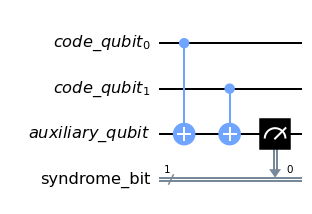

In [ ]:
# Block 4- Creating circuit with syndrome bits. Here, we are separately creating the code qubits and the syndrome qubit using QuantumRegisters
cq = QuantumRegister(2, 'code_qubit')
lq = QuantumRegister(1, 'auxiliary_qubit')
sb = ClassicalRegister(1, 'syndrome_bit')
qc = QuantumCircuit(cq, lq, sb)
qc.cx(cq[0], lq[0])
qc.cx(cq[1], lq[0])
qc.measure(lq, sb)
qc.draw()

Here we have three physical qubits. Two are called 'code qubits', and the other is called an 'auxiliary qubit'. One bit of output is extracted, called the syndrome bit. The auxiliary qubit is always initialized in state $\left|0\right\rangle$. The code qubits, however, can be initialized in different states. To see what affect different inputs have on the output, we can create a circuit `qc_init` that prepares the code qubits in some state, and then run the circuit `qc_init+qc`.

First, the trivial case: `qc_init` does nothing, and so the code qubits are initially $\left|00\right\rangle$.

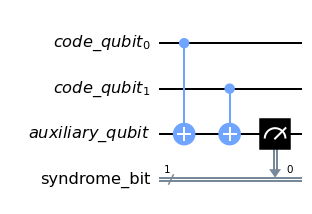

In [ ]:
# Block 5 - Draw the circuit in case the initial state is |00>
qc_init = QuantumCircuit(cq)
qc.compose(qc_init, front=True).draw() # THis line adds qc_init to the overall circuit qc and then draws it

In [ ]:
# Block 6 - Simulate the circuit

sim_backend = QasmSimulator(method = "automatic")
job = execute(qc, sim_backend, shots = 1024)
results = job.result()
counts = results.get_counts()
print('Results:',counts)

Results: {'0': 1024}


The outcome, in all cases, is `0`.

Now let's try an initial state of $\left|11\right\rangle$.

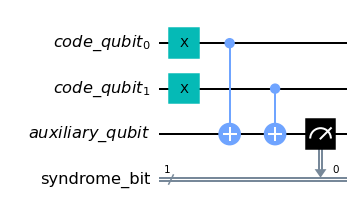

In [ ]:
# Block 7 - Create a quantum circuit to make the state |11>. Draw the circuit
qc_init = QuantumCircuit(cq)
qc_init.x(cq)
qc.compose(qc_init, front=True).draw()

In [ ]:
# Block 8 - Simulate the circuit
sim_backend = QasmSimulator(method = "automatic")
job = execute(qc, sim_backend, shots = 1024)
results = job.result()
counts = results.get_counts()
print('Results:',counts)

Results: {'0': 1024}


The outcome in this case is also always `0`. Given the linearity of quantum mechanics, we can expect the same to be true also for any superposition of $\left|00\right\rangle$ and $\left|11\right\rangle$, such as the example below.

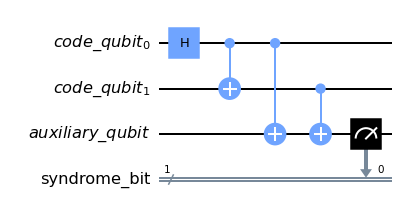

In [ ]:
# Block 9 -Create a circuit to make the entangled state |00> + |11> and add it to the overall circuit qc
qc_init = QuantumCircuit(cq)
qc_init.h(cq[0])
qc_init.cx(cq[0], cq[1])
qc.compose(qc_init, front=True).draw()

In [ ]:
# Block 10 - Simulate the circuit
sim_backend = QasmSimulator(method = "automatic")
job = execute(qc, sim_backend, shots = 1024)
results = job.result()
counts = results.get_counts()
print('Results:',counts)

Results: {'0': 1024}


The opposite outcome will be found for an initial state of $\left|01\right\rangle$, $\left|10\right\rangle$ or any superposition thereof.

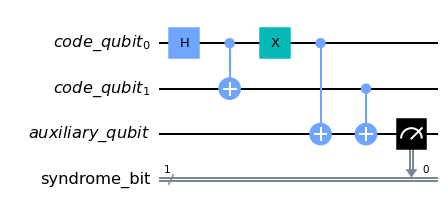

In [ ]:
# Block 11 -Create a circuit to make the entangled state |01> + |10> and add it to the overall circuit qc

qc_init = QuantumCircuit(cq)
qc_init.h(cq[0])
qc_init.cx(cq[0], cq[1])
qc_init.x(cq[0])
qc.compose(qc_init, front=True).draw()

In [ ]:
# Block 12 - Simulate the circuit
sim_backend = QasmSimulator(method = "automatic")
job = execute(qc, sim_backend, shots = 1024)
results = job.result()
counts = results.get_counts()
print('Results:',counts)

Results: {'0': 1024}


In such cases the output is always `'1'`.

This measurement is therefore telling us about a collective property of multiple qubits. Specifically, it looks at the two code qubits and determines whether their state is the same or different in the z basis. For basis states that are the same in the z basis, like $\left|00\right\rangle$ and $\left|11\right\rangle$, the measurement simply returns `0`. It also does so for any superposition of these. Since it does not distinguish between these states in any way, it also does not collapse such a superposition.

Similarly, For basis states that are different in the z basis it returns a `1`. This occurs for $\left|01\right\rangle$, $\left|10\right\rangle$ or any superposition thereof.

Now suppose we apply such a 'syndrome measurement' on all pairs of physical qubits in our repetition code. If their state is described by a repeated $\left|0\right\rangle$, a repeated $\left|1\right\rangle$, or any superposition thereof, all the syndrome measurements will return `0`. Given this result, we will know that our states are indeed encoded in the repeated states that we want them to be, and can deduce that no errors have occurred. If some syndrome measurements return `1`, however, it is a signature of an error. We can therefore use these measurement results to determine how to decode the result.